# Merian Introduction to the Rubin Science Pipelines

This notebook gives an introduction to using the Rubin Science Pipelines to interact with processed Merian data.

Full documentation and more information can be found at: https://pipelines.lsst.io/. In addition to this notebook, please also refer to https://pipelines.lsst.io/getting-started, which contains additional resources to help get you up and running.

If you have any further questions about anything below, please direct them to Lee Kelvin on the Merian Slack, and I'd be happy to help.

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

import lsst
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

## Setting up the Science Pipelines

To begin, we first set up the Science Pipelines (SP). The Rubin Observatory Data Management team (DM) maintains a shared software 'stack' on the `tiger` clusters at Princeton, which can be used directly. Alternatively, it's also possible to build your own stack on a local machine (such as another local server or even a laptop) if needed. The instructions below show the steps required to set up the SP when using the shared stack.

First, source the load script. Either add this into your `.bashrc`, or run it directly in the terminal at the beginning of each session:

    $ source /projects/HSC/LSST/stack/loadLSST.bash

Next, load the `lsst_distrib` package using the `setup` command from the `eups` package manager:

    $ setup lsst_distrib

We now have access to the full suite of SP data processing tools. By default, the above command will setup the latest available weekly build of the stack, however, additional builds from prior weeklies can also be loaded if required (using the `-t` argument). Use `eups` to check that the `lsst_distrib` package has been correctly setup, which should have the `setup` tag appended if so:

    $ eups list lsst_distrib

It should now be possible to access Merian data products from the command line, perform queries, and/or load up a python instance or a jupyter notebook/lab to interact with the data more directly.

## Setting up Jupyter Lab

It's not necessary to set up Jupyter to interact with the SP, however, we opt to do so here to allow for python code and plotting to live side-by-side.

> You may find that your own particular instance of Jupyter is not set up to use the version of Python that came installed with the SP. If your version of Python is new enough, this might not be an issue in most cases. To avoid any potential version mismatch issues however, you can edit the `~/.local/share/jupyter/kernels/python3/kernel.json` file to point towards the stack installed python instead (`$CONDA_PREFIX/bin/python`).

To set up Jupyter, you'll first need to forward a port via ssh to your local machine:

    ssh -L XXXXX:localhost:XXXXX -J tigressgateway tiger

where `tigressgateway` and `tiger` are machine aliases defined elsewhere (e.g., within your `~/.ssh/config` file). Next, on tiger, run `setup lsst_distrib` first, and then start a jupyter lab instance using:

    jupyter lab --no-browser --port=XXXXX --ServerApp.token="MYTOKEN"

Finally, open up a web browser on your local machine and navigate to:

    localhost:XXXXX/?token=MYTOKEN

## Data Repository

All data within the SP are located in a repository. Here we establish an alias for the location of the Merian repo on the command line:

    REPO=/projects/MERIAN/repo

and in python:

In [2]:
repo = '/projects/MERIAN/repo'

## The Butler

The 'butler' is the name given to the tool which is used to access, query and interact with data stored in the repository. After having set up `lsst_distrib` on the command line, `butler -h` should show a range of options to further interact with the data:

    butler -h

It's also possible (and often recommended) to set up a butler within python to interact with the repo. To do so, we instantiate a butler with our repo of choice using `dafButler`:

In [3]:
butler = dafButler.Butler(repo)

## Collections

Data processed by the SP are stored in `collections`. Collections are typically of the RUN type, however, other types exist including CHAINED collections (groups of collections) and CALIBRATION collections (collections which hold calibration data). Collections are queried on the command line like this:
    
    butler query-collections $REPO
    
    butler query-collections $REPO --chains TREE
    
    butler query-collections $REPO --chains TREE *u/lskelvin*

and in python like this:

In [4]:
list(butler.registry.queryCollections())

['DECam/raw/all',
 'DECam/calib',
 'DECam/calib/unbounded',
 'DECam/calib/curated/19700101T000000Z',
 'DECam/calib/curated/20130115T013000Z',
 'DECam/calib/curated/20130916T092600Z',
 'DECam/calib/curated/20140117T012900Z',
 'DECam/calib/curated/20141020T103000Z',
 'DECam/calib/curated/20150105T011500Z',
 'DECam/calib/curated/20131130T000000Z',
 'refcats',
 'DECam/defaults',
 'skymaps',
 'DECam/calib/merian/bias-01',
 'DECam/calib/merian',
 'DECam/calib/merian/crosstalk-01',
 'DECam/calib/merian/flat-01-DETECTOR',
 'DECam/calib/merian/flat-01',
 'DECam/calib/merian/flat-01-30708',
 'u/lskelvin/testing-isr',
 'u/lskelvin/testing-characterizeImage',
 'u/lskelvin/testing-calibrate',
 'u/lskelvin/testing']

In [5]:
list(butler.registry.queryCollections(re.compile('.*lskelvin.*')))

['u/lskelvin/testing-isr',
 'u/lskelvin/testing-characterizeImage',
 'u/lskelvin/testing-calibrate',
 'u/lskelvin/testing']

## Dataset Types

Available dataset types can be listed on the command line:

    butler query-dataset-types $REPO
    
    butler query-dataset-types $REPO *calexp*

and within python:

In [6]:
list(butler.registry.queryDatasetTypes())

[DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('crosstalk', {instrument, detector}, CrosstalkCalib, isCalibration=True),
 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True),
 DatasetType('linearizer', {instrument, detector}, Linearizer, isCalibration=True),
 DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog),
 DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog),
 DatasetType('skyMap', {skymap}, SkyMap),
 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet),
 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True),
 DatasetType('cpBiasCombine_metadata', {instrument, detector}, PropertySet),
 DatasetType('isr_config', {}, Config),
 DatasetType('cpBiasCombine_config', {}, Config

In [7]:
list(butler.registry.queryDatasetTypes(re.compile('.*calexp.*')))

[DatasetType('calexpBackground', {band, instrument, detector, physical_filter, visit_system, visit}, Background),
 DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF)]

## Pipelines

The standard single-frame pipeline, `ProcessCcd`, takes raw data and outputs it into a calibrated exposure, or 'calexp'. This pipeine looks like this: https://tigress-web.princeton.edu/~lkelvin/merian/pipeline-ProcessCcd.pdf.

To print out the tasks which are performed in the `ProcessCcd` pipeline, we can use the `pipetask build` command:

    pipetask build -p $AP_PIPE_DIR/pipelines/DarkEnergyCamera/ProcessCcd.yaml --show pipeline
    
where `$AP_PIPE_DIR/pipelines/DarkEnergyCamera/ProcessCcd.yaml` is the location of the currently used single frame data reduction pipeline for Merian/DECam data.

Briefly, the `ProcessCcd` pipeline currently performs three tasks:

* IsrTask
  * crosstalk correction
  * CCD assembly
  * bias correction
  * linearization
  * bad pixel masking and interpolation (defects, suspects, NaNs, etc)
  * flat correction
  * post ISR image statistics (e.g., sky level estimation)
* CharacterizeImageTask
  * cosmic ray detection
  * initial source detection and characterization
  * background estimation and subtraction
  * PSF estimation
  * calculation of aperture corrections
  * measurement of exposure statistics
* calibrateTask
  * resubtraction of background following source detection
  * injection of sky sources (pseudo-sources placed randomly on empty patches of sky)
  * source deblending
  * application of aperture corrections
  * astrometric calibration
  * photometric calibration

## Datasets

We can use the butler to find out where a specific dataset lives, for example:

    butler query-datasets $REPO calexp

From this query, we note that calexps are stored within the `u/lskelvin/testing` collection.

To list available datasets in the repository which are stored within a specific collection, on the command line:

    butler query-datasets $REPO --collections u/lskelvin/testing

We may also narrow our search to specific dimensions of interest using a `dataId`:

    dataId="instrument='DECam' AND exposure=971666 AND detector=1"
    
    butler query-datasets $REPO --collections u/lskelvin/testing --where "$dataId" calexp

It is possible to list the file path to a requested FITS file by appending `--show-uri`, however, this is not normally recommended (python should be preferred in almost all cases):

    butler query-datasets $REPO --collections u/lskelvin/testing --where "$dataId" calexp --show-uri

## Getting Data

Within python, use the butler to get a specific dataset:

In [8]:
calexp = butler.get('calexp', collections='u/lskelvin/testing', instrument='DECam', visit=971666, detector=1)

Instead of passing the dimension references as arguments, they may also be supplied using a `dataId` dictionary. This is useful, as it allows the dictionary to be defined once and used multiple times throughout a script:

In [9]:
dataId = dict(instrument='DECam', visit=971666, detector=1)
calexp = butler.get('calexp', collections='u/lskelvin/testing', dataId=dataId)

Now the dataset type is loaded, we can take a look at some of the methods and properties associated with it:

In [10]:
print(dir(calexp))

['Factory', '__add__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '_get', '_set', 'clone', 'convertD', 'convertF', 'dtype', 'getBBox', 'getCutout', 'getDetector', 'getDimensions', 'getFilter', 'getFilterLabel', 'getHeight', 'getImage', 'getInfo', 'getMask', 'getMaskedImage', 'getMetadata', 'getPhotoCalib', 'getPsf', 'getVariance', 'getWcs', 'getWidth', 'getX0', 'getXY0', 'getY0', 'hasPsf', 'hasWcs', 'image', 'mask', 'maskedImage', 'readFits', 'readFitsWithOptions', 'setDetector', 'setFilter', 'setFilterLabel', 'setImage', 'setInfo', 'setMask', 'setMaskedImage', 'setMetadata', 'setPhotoCalib', 'setPsf

## AFW Images

An AFW image contains three data frames, image, mask and variance, in addition to ancilliary data associated with the exposure. The data frames can be converted into a numpy array for quick analysis:

In [11]:
calexp.image.array

array([[-0.70471966, -0.70234317, -0.6999853 , ...,  0.50497097,
         0.5056769 ,  0.50639105],
       [-0.7041877 , -0.7018154 , -0.69945806, ...,  0.50445473,
         0.50516194,  0.50587356],
       [-0.70365953, -0.70128775, -0.69893074, ...,  0.5039377 ,
         0.5046424 ,  0.5053553 ],
       ...,
       [-0.48725244, -0.48565525, -0.48407304, ...,  0.3961242 ,
         0.39769408,  0.39928186],
       [-0.4871616 , -0.48556685, -0.48398712, ...,  0.39600974,
         0.39757505,  0.39916205],
       [-0.48706764, -0.48547533, -0.48389807, ...,  0.39589104,
         0.39745942,  0.39904183]], dtype=float32)

In [12]:
calexp.mask.array

array([[405, 405, 405, ..., 405, 405, 405],
       [405, 405, 405, ..., 405, 405, 405],
       [405, 405, 405, ..., 405, 405, 405],
       ...,
       [405, 405, 405, ..., 405, 405, 405],
       [405, 405, 405, ..., 405, 405, 405],
       [405, 405, 405, ..., 405, 405, 405]], dtype=int32)

In [13]:
calexp.variance.array

array([[38.885498, 38.885498, 38.885498, ..., 38.885498, 38.885498,
        38.885498],
       [38.885498, 38.885498, 38.885498, ..., 38.885498, 38.885498,
        38.885498],
       [38.885498, 38.885498, 38.885498, ..., 38.885498, 38.885498,
        38.885498],
       ...,
       [38.885498, 38.885498, 38.885498, ..., 38.885498, 38.885498,
        38.885498],
       [38.885498, 38.885498, 38.885498, ..., 38.885498, 38.885498,
        38.885498],
       [38.885498, 38.885498, 38.885498, ..., 38.885498, 38.885498,
        38.885498]], dtype=float32)

Various methods are associated with each data frame, for example, to see the mask plane bit map dictionary:

In [14]:
calexp.mask.getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'CROSSTALK': 9,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7,
 'UNMASKEDNAN': 10}

## Visualize Images

Images can be visualized using the `afwDisplay` image plotting routines. Alternatively, the above numpy arrays can also be plotted using your own plotting routines and `matplotlib`.

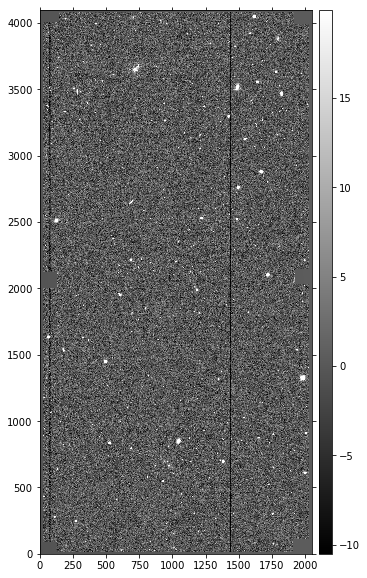

In [15]:
fig = plt.figure(figsize=(10,10))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(calexp.image)

## Source Catalogues

The primary output catalogues following single frame processing associated with the calibrated exposure (calexp) file are source catalogues (`src`). These are accessed using the butler:

In [16]:
src = butler.get('src', collections='u/lskelvin/testing', instrument='DECam', visit=971666, detector=1)
print(f'number of rows = {len(src.asAstropy())}')
print(f'number of columns = {len(src.asAstropy().columns)}')

number of rows = 1595
number of columns = 413


In [17]:
src.asAstropy()[:5]

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,sky_source,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMomentsDebia

A few examples interacting with the source catalogue:

In [18]:
[x for x in src.asAstropy().columns if 'SdssShape_instFlux' in x]

['base_SdssShape_instFlux',
 'base_SdssShape_instFluxErr',
 'base_SdssShape_instFlux_xx_Cov',
 'base_SdssShape_instFlux_yy_Cov',
 'base_SdssShape_instFlux_xy_Cov']

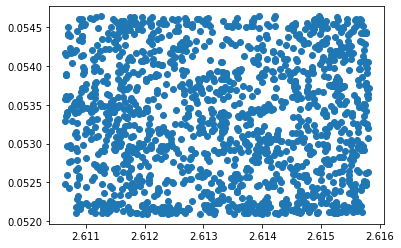

In [19]:
_ = plt.scatter(src['coord_ra'], src['coord_dec'])

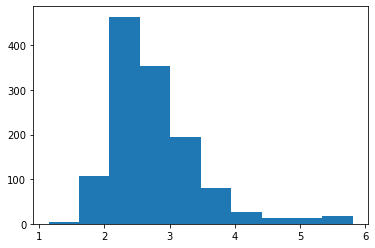

In [20]:
_ = plt.hist(np.log10(src['base_SdssShape_instFlux']))

## Useful Extras

### photometric calibration and zero point magnitude

In [21]:
photoCalib = calexp.getPhotoCalib()

magZP = photoCalib.instFluxToMagnitude(1)
print(f'{magZP = }')

instFluxToNanojansky = photoCalib.instFluxToNanojansky(1)
print(f'1 count = {instFluxToNanojansky} nJy')

magZP = 27.965475656851666
1 count = 23.64883424184348 nJy


### Point spread function (PSF) parameters

Note: This measure of PSF sigma calculated here is technically the 'second-moments determinant radius', and is about as close to a 'sigma' as one can get for a non-Gaussian PSF (it is exactly sigma for a truly Gaussian PSF).

fwhmPerSigma = 2.3548200450309493
psfSigma = 1.5621180480153134
psfFwhm = 3.678506892171079


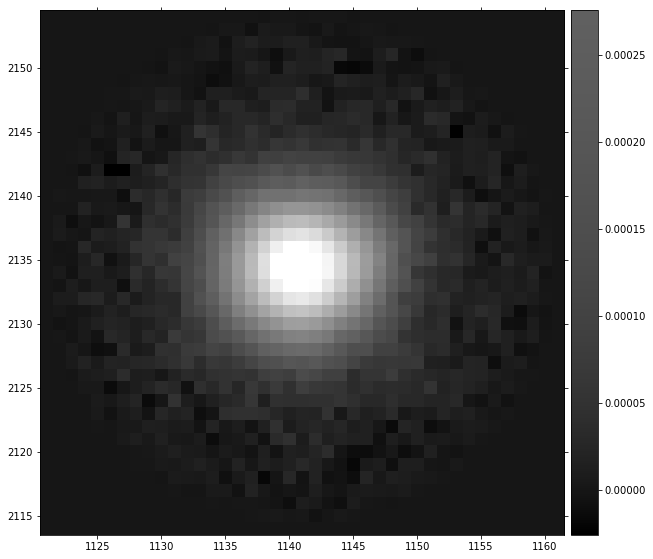

In [22]:
psf = calexp.getPsf()

fig = plt.figure(figsize=(10,10))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("asinh", "zscale")
display.mtv(psf.computeImage().convertF())

fwhmPerSigma = 2 * np.sqrt(2 * np.log(2))
psfSigma = psf.computeShape().getDeterminantRadius()
psfFwhm = fwhmPerSigma * psfSigma
print(f'{fwhmPerSigma = }')
print(f'{psfSigma = }')
print(f'{psfFwhm = }')

### WCS conversion

In [23]:
wcs = calexp.getWcs()

print(wcs, end='\n\n')

print(f'pixel [1,1] has sky coordinates {wcs.pixelToSky(1, 1)} degrees', end='\n\n')

radec = lsst.geom.SpherePoint(149.58, 3.13, lsst.geom.degrees)
print(f'sky position RA={radec.getRa().asDegrees()} deg, dec={radec.getDec().asDegrees()} deg has a pixel '
      f'position of {wcs.skyToPixel(radec)}')

FITS standard SkyWcs:
Sky Origin: (149.7276659550, +3.0564726728)
Pixel Origin: (1039.18, 2059.63)
Pixel Scale: 0.262687 arcsec/pixel

pixel [1,1] has sky coordinates (149.5774514344, +3.1319997588) degrees

sky position RA=149.58 deg, dec=3.13 deg has a pixel position of (28.487, 36.105)


## Not covered here

Not covered here are instructions for running `pipetask run`, the main command used to re-reduce data. Efforts are still ongoing to improve Merian-acquired DECam processing, and I hope to have more information on this shortly.

## Summary

This notebook gives an overview on how to interact with the Rubin Science Pipelines data currently stored in the Merian repository on `tiger`. More information can be found on https://pipelines.lsst.io/. Please feel free to contact me (Lee Kelvin) on Slack if there is anything else I can help with regards getting started.